In [76]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200


from model_loader_CP2 import *
import Unet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.97 ms


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

time: 1.39 ms


In [3]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

time: 665 µs


In [4]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

time: 690 µs


In [5]:
#get sample
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder,scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

time: 1.08 ms


In [6]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([3, 6, 3, 256, 306])
time: 138 ms


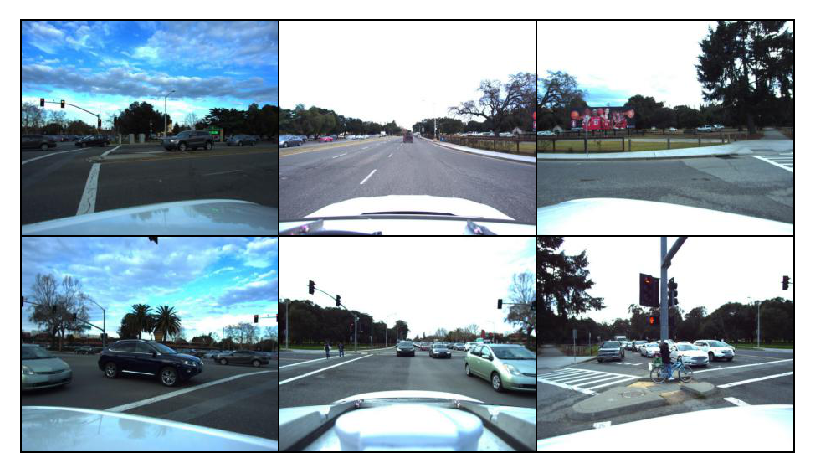

time: 314 ms


In [7]:
#The 6 images orgenized in the following order:
# 0 CAM_FRONT_LEFT, 1 CAM_FRONT, 2 CAM_FRONT_RIGHT, 3 CAM_BACK_LEFT, 4 CAM_BACK, 5 CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0)) #need the transpose
plt.axis('off');

In [8]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
LB_trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

time: 107 ms


In [9]:
sample, target, road_image, extra = iter(LB_trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])
time: 264 ms


In [26]:
toImg = transforms.ToPILImage()

time: 644 µs


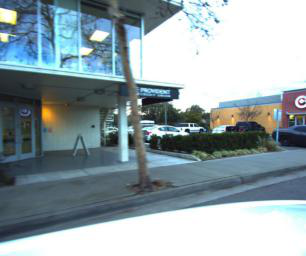

time: 28.7 ms


In [32]:

toImg(sample[0][5])

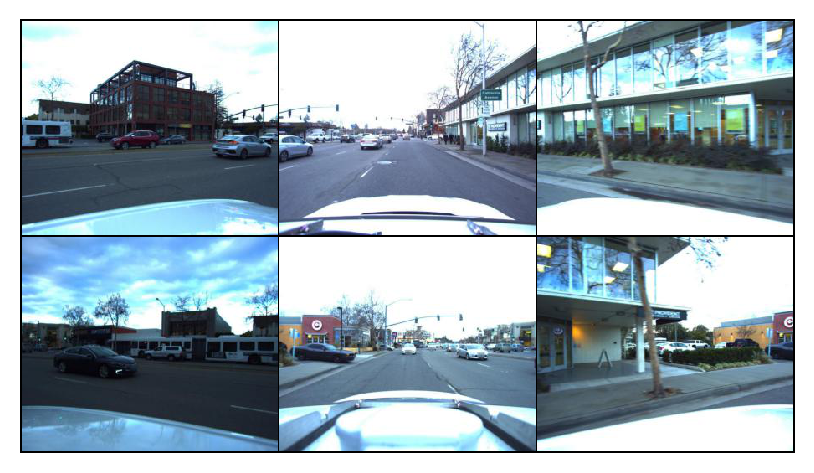

time: 299 ms


In [10]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0)) #need the transpose
plt.axis('off');

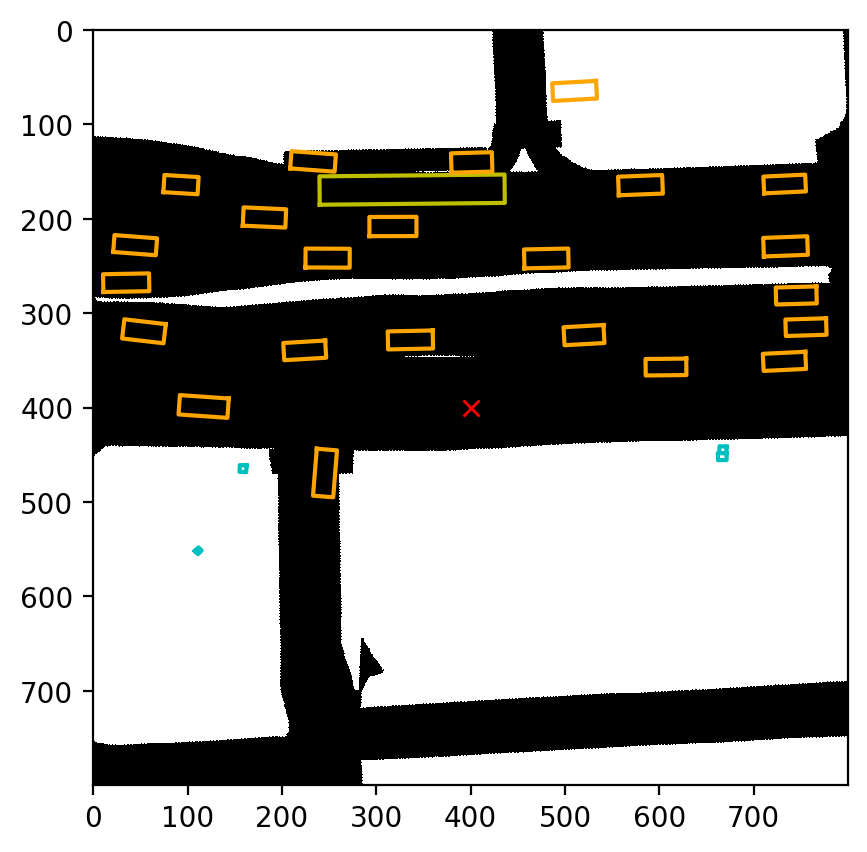

time: 272 ms


In [11]:
## ROAD IMAGE ##
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

In [12]:
road_image[0].size()

torch.Size([800, 800])

time: 1.82 ms


In [13]:
sample_ = ModelLoader.get_binary_road_map(sample)

test func
time: 54 ms


In [14]:
sample_[0].size()

torch.Size([880, 880])

time: 1.68 ms


In [15]:
#min max is between 0 and 1
print(sample_[0].min())
print(sample_[1].max())

tensor(0.0092)
tensor(1.)
time: 2.68 ms


In [16]:
import torchvision.models as models
resnet18_pre = models.resnet18(pretrained=True)
resnet18_raw = models.resnet18(pretrained=False)

time: 340 ms


In [17]:
#create a normalize tranform 
res_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

time: 700 µs


In [19]:
#resnet requires all sizes to be 224 by 224
res_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])

time: 803 µs


In [62]:
comb_img = ModelLoader.sew_images(sample[0])

T1 shape torch.Size([256, 918])
comb1 shape torch.Size([512, 918])
time: 17.4 ms


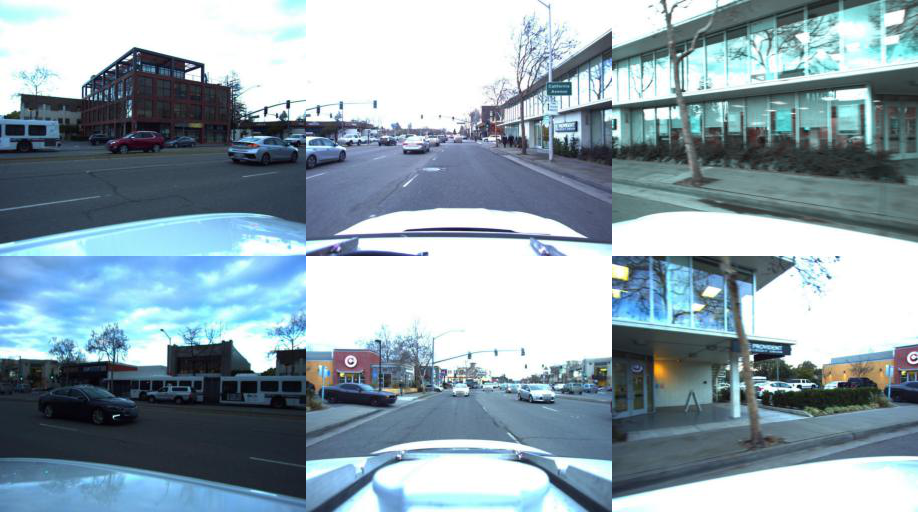

time: 93.7 ms


In [63]:
comb_img

In [64]:
res_comb_img = res_transform(comb_img)

time: 4.27 ms


In [65]:
res_comb_img.shape

torch.Size([3, 224, 224])

time: 1.61 ms


In [66]:
##to be put in separate py file
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

time: 962 µs


In [67]:
def freeze_model(model): #feature extract
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model): #finetune 
    for param in model.parameters():
        param.requires_grad = True

time: 985 µs


In [69]:
num_ftrs = resnet18_pre.fc.in_features
resnet18_pre.fc = Identity() #first set it to identity

time: 792 µs
